### Подключение необходимых библиотек

In [1]:
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Подключение выборок

In [2]:
# Загрузка массивов из файлов
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# Проверка результатов
print("Массивы успешно загружены")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Массивы успешно загружены
(72000, 768)
(72000, 3)
(18000, 768)
(18000, 3)


### Сервисная функция для обучения и просмотра результата обчения нейросети

In [3]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()
    
    callback = EarlyStopping(monitor='val_accuracy', patience=50)

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[callback])

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)#Целочисленные координаты оси абсцисс установлены
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    plt.style.use('default')
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

    model.save(f"{title}.h5")

class_labels = ['negative', 'positive', 'neutral']

# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=class_labels,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### Модель №1

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,494,979 (5.70 MB)

 Trainable params: 1,490,947 (5.69 MB)

 Non-trainable params: 4,032 (15.75 KB)

Epoch 1/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4416 - loss: 1.3114 - val_accuracy: 0.6147 - val_loss: 0.8275
Epoch 2/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5737 - loss: 0.9187 - val_accuracy: 0.6479 - val_loss: 0.7770
Epoch 3/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6064 - loss: 0.8406 - val_accuracy: 0.6568 - val_loss: 0.7495
Epoch 4/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6284 - loss: 0.8033 - val_accuracy: 0.6534 - val_loss: 0.7452
Epoch 5/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6415 - loss: 0.7818 - val_accuracy: 0.6751 - val_loss: 0.7203
Epoch 6/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6566 - loss: 0.7574 - val_accuracy: 0.6749 - val_loss: 0.7163
Epoch 7/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6575 - loss: 0.7538 - val_accuracy: 0.6746 - val_loss: 0.7184
Epoch 8/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6664 - loss

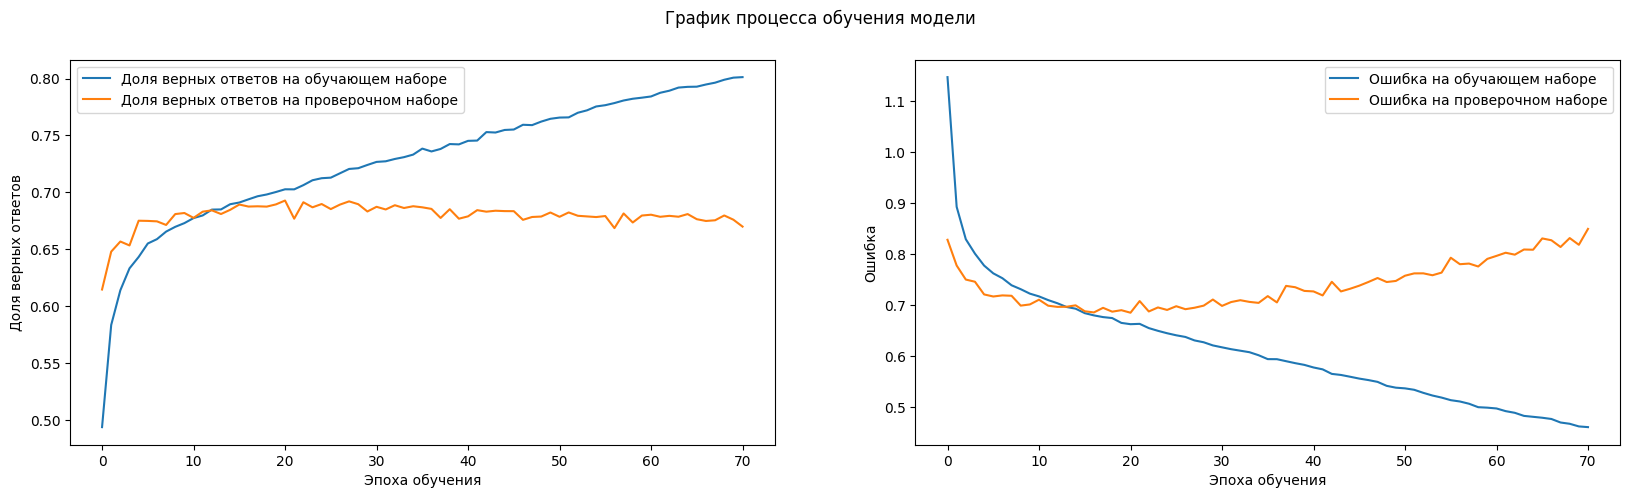

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


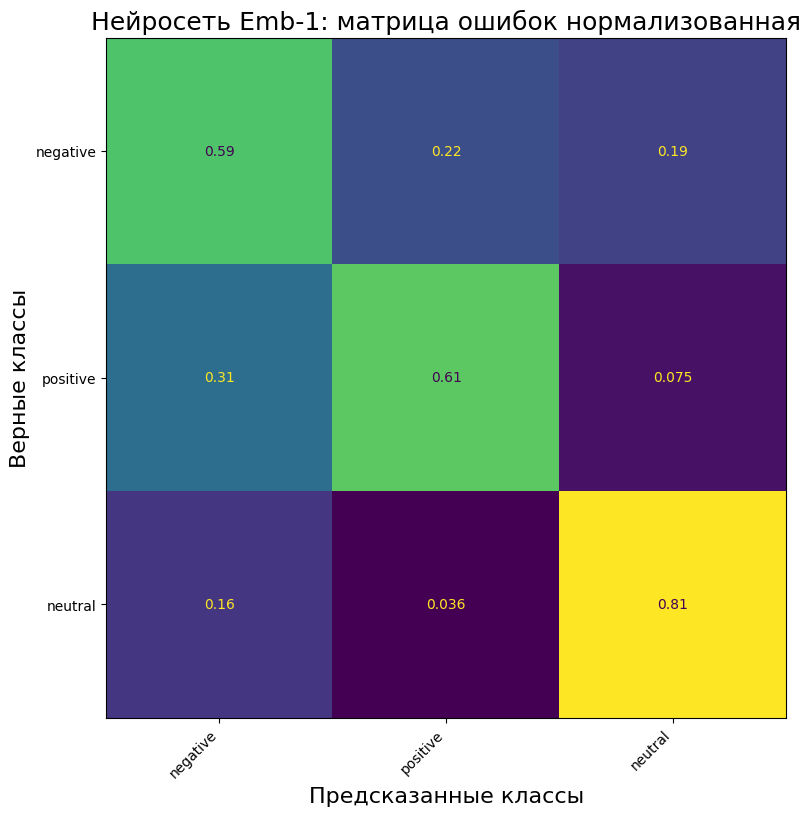

----------------------------------------------------------------------------------------------------
Нейросеть: Emb-1
Класс: negative              59% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              61% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               80% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  67%


In [4]:
class_labels = ['negative', 'positive', 'neutral']


# Создание модели
model_1 = Sequential()

model_1.add(Dense(1024, input_dim=768, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(256, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(128, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(64, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(32, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(BatchNormalization())
model_1.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_1,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb-1',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=100,
                         batch_size=64)

### Модель №2

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,494,851 (5.70 MB)

 Trainable params: 1,490,883 (5.69 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5501 - loss: 0.9645 - val_accuracy: 0.6435 - val_loss: 0.7733
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6707 - loss: 0.7235 - val_accuracy: 0.6370 - val_loss: 0.7963
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6969 - loss: 0.6737 - val_accuracy: 0.6434 - val_loss: 0.7867
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7085 - loss: 0.6468 - val_accuracy: 0.6555 - val_loss: 0.7534
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7317 - loss: 0.6092 - val_accuracy: 0.6536 - val_loss: 0.7649
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7425 - loss: 0.5839 - val_accuracy: 0.6619 - val_loss: 0.7483
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7618 - loss: 0.5496 - val_accuracy: 0.6617 - val_loss: 0.7757
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7790 - loss: 0.5164 - 

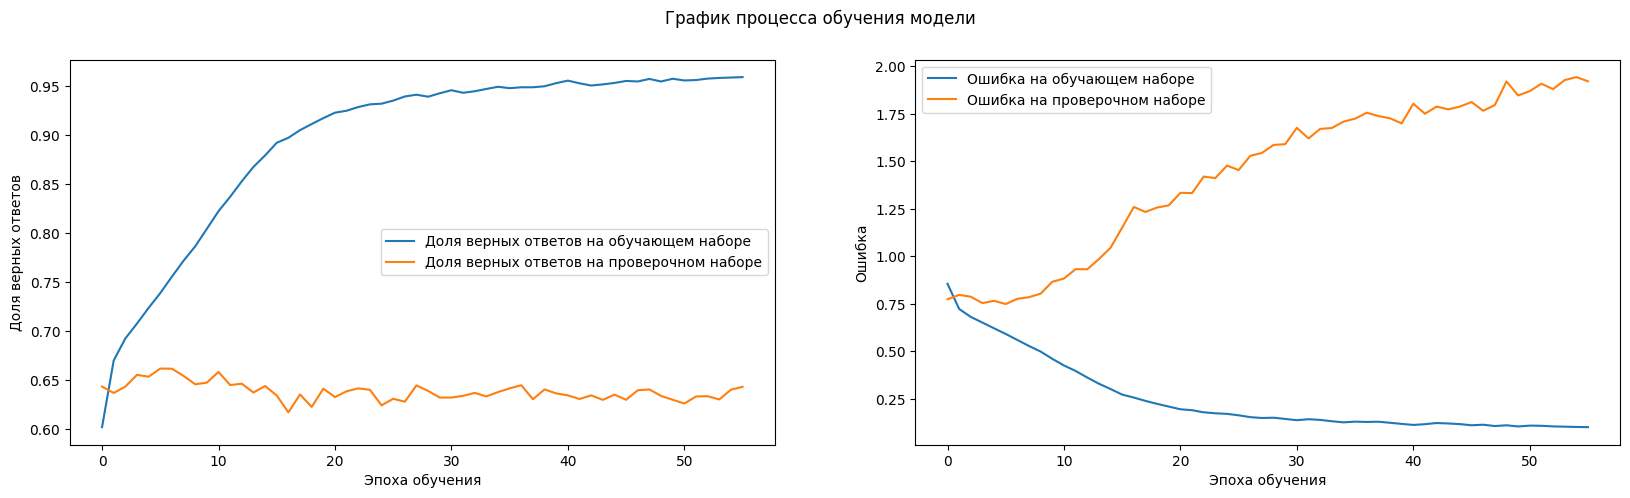

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


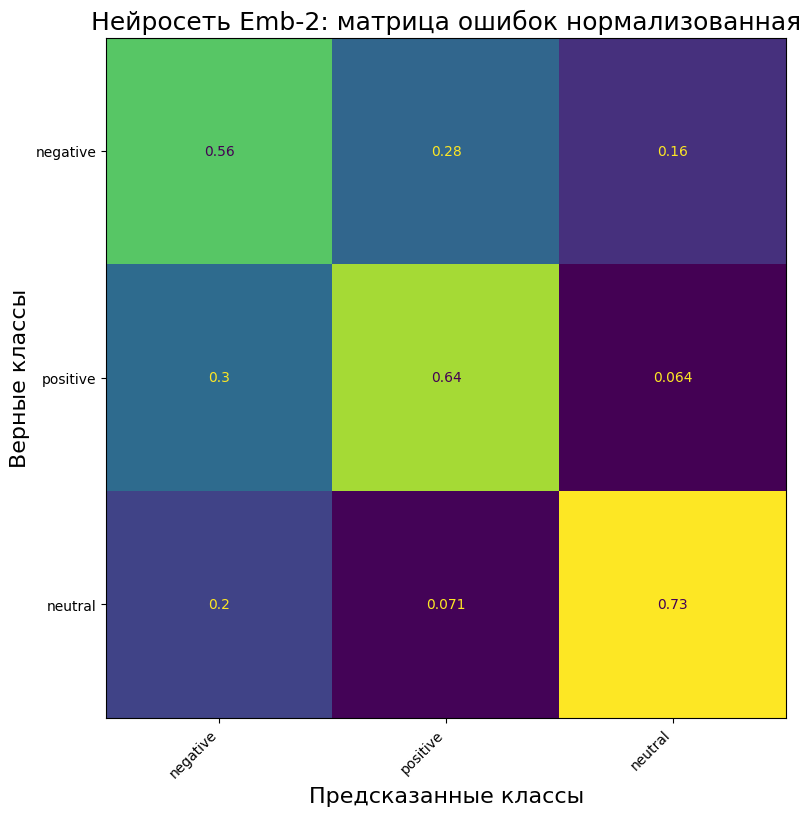

----------------------------------------------------------------------------------------------------
Нейросеть: Emb-2
Класс: negative              56% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              64% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               73% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  64%


In [5]:
class_labels = ['negative', 'positive', 'neutral']


# Создание модели
model_2 = Sequential()

model_2.add(Dense(1024, input_dim=768, activation="relu"))
model_2.add(BatchNormalization())
model_2.add(Dense(512, activation="relu"))
model_2.add(BatchNormalization())
model_2.add(Dense(256, activation="relu"))
model_2.add(BatchNormalization())
model_2.add(Dense(128, activation="relu"))
model_2.add(BatchNormalization())
model_2.add(Dense(64, activation="relu"))
model_2.add(BatchNormalization())
model_2.add(Dense(32, activation="relu"))
model_2.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_2,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb-2',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=100,
                         batch_size=128)

### Модель №3

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,195 (938.26 KB)

 Trainable params: 240,195 (938.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5423 - loss: 0.9604 - val_accuracy: 0.6366 - val_loss: 0.7890
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6478 - loss: 0.7769 - val_accuracy: 0.6551 - val_loss: 0.7548
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6547 - loss: 0.7572 - val_accuracy: 0.6581 - val_loss: 0.7516
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6613 - loss: 0.7397 - val_accuracy: 0.6696 - val_loss: 0.7274
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6705 - loss: 0.7239 - val_accuracy: 0.6708 - val_loss: 0.7249
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6773 - loss: 0.7133 - val_accuracy: 0.6791 - val_loss: 0.7116
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6823 - loss: 0.6991 - val_accuracy: 0.6814 - val_loss: 0.7044
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6864 - loss: 0.6939 - val_accu

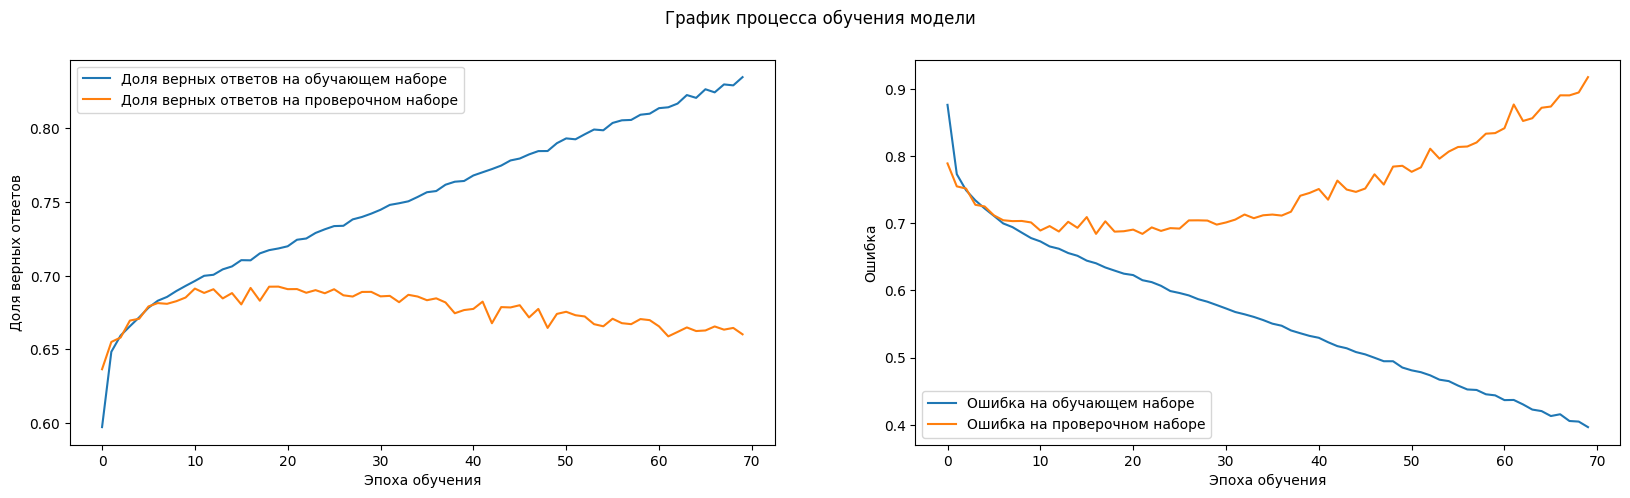

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


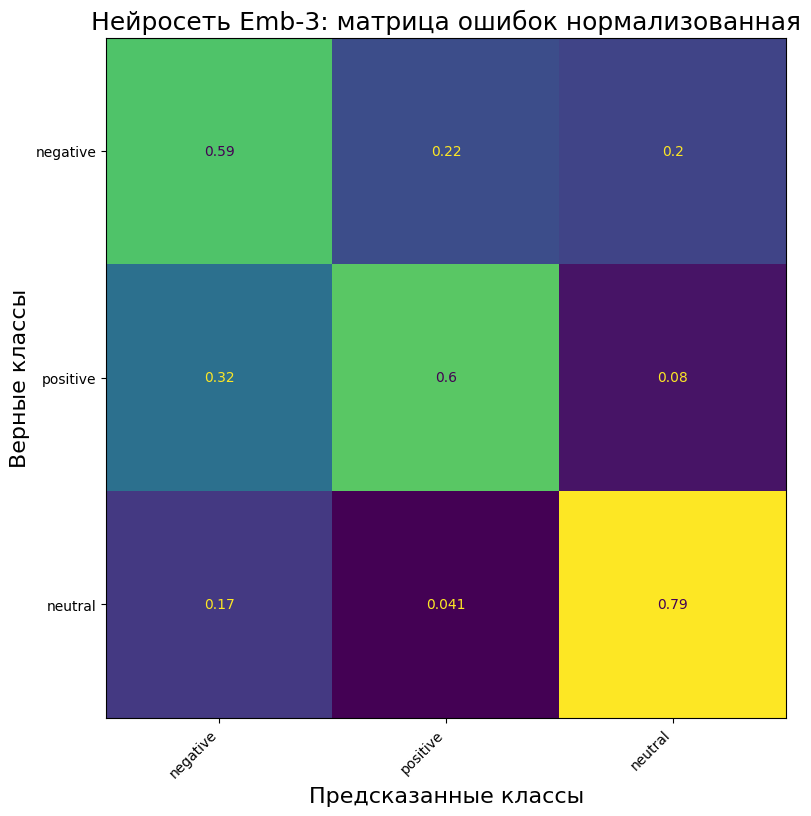

----------------------------------------------------------------------------------------------------
Нейросеть: Emb-3
Класс: negative              59% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              60% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               79% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  66%


In [6]:
class_labels = ['negative', 'positive', 'neutral']


# Создание модели
model_3 = Sequential()

model_3.add(Dense(256, input_dim=768, activation="relu"))
model_3.add(Dense(128, activation="relu"))
model_3.add(Dense(64, activation="relu"))
model_3.add(Dense(32, activation="relu"))
model_3.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_3,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb-3',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=100,
                         batch_size=256)

### Модель №4

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,867 (2.17 MB)

 Trainable params: 568,867 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3350 - loss: 1.1407 - val_accuracy: 0.3808 - val_loss: 1.0957
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3431 - loss: 1.1037 - val_accuracy: 0.4267 - val_loss: 1.0926
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3648 - loss: 1.0934 - val_accuracy: 0.4696 - val_loss: 1.0785
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3938 - loss: 1.0790 - val_accuracy: 0.4843 - val_loss: 1.0311
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4412 - loss: 1.0411 - val_accuracy: 0.5396 - val_loss: 0.9620
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4886 - loss: 0.9832 - val_accuracy: 0.5666 - val_loss: 0.9069
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5286 - loss: 0.9343 - val_accuracy: 0.5704 - val_loss: 0.8795
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5435 - loss: 0.9111 - val_accuracy: 0.

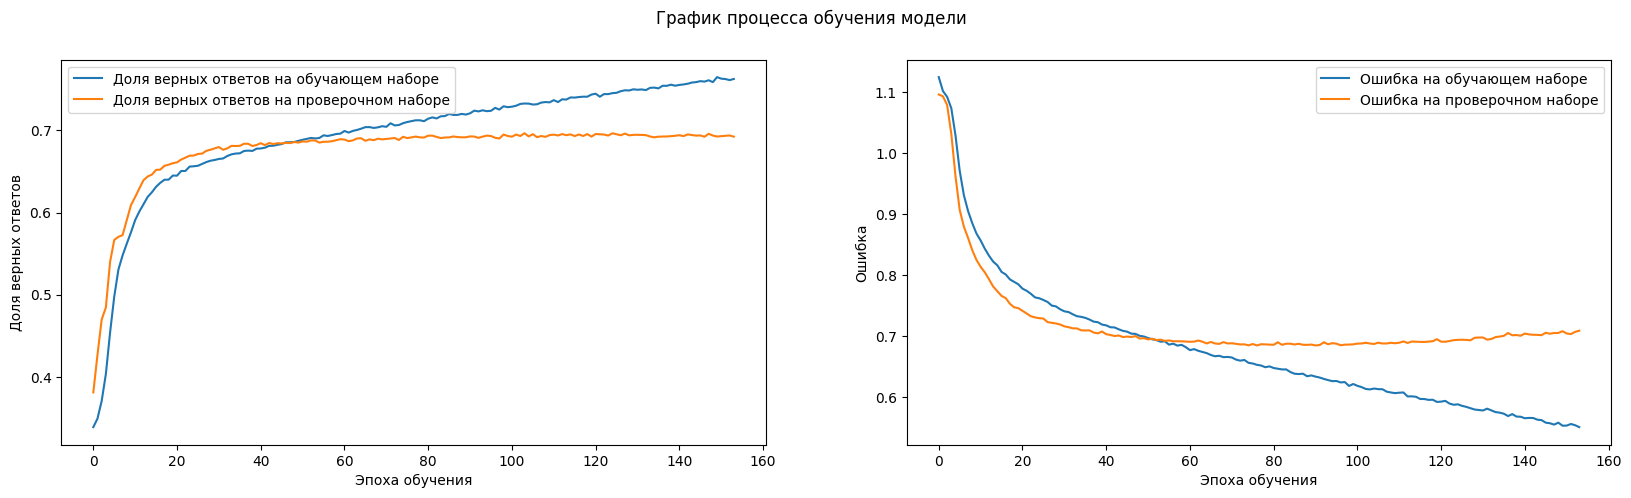

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


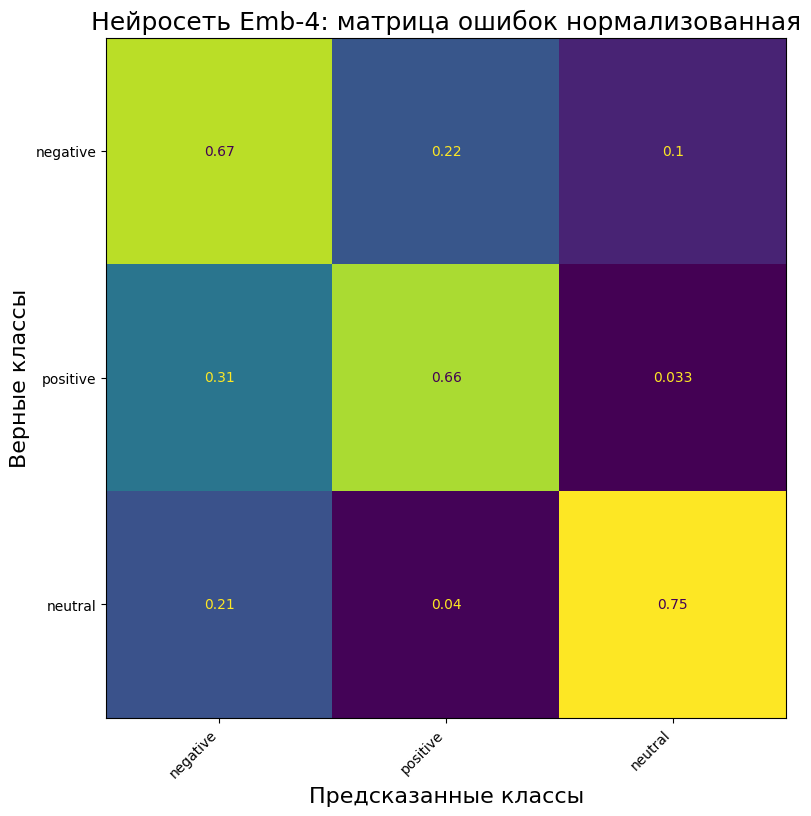

----------------------------------------------------------------------------------------------------
Нейросеть: Emb-4
Класс: negative              67% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              66% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               75% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  69%


In [7]:
class_labels = ['negative', 'positive', 'neutral']

# Создание модели
model_4 = Sequential()

model_4.add(Dense(512, input_dim=768, activation="relu"))
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation="relu"))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation="relu"))
model_4.add(Dropout(0.5))
model_4.add(Dense(64, activation="relu"))
model_4.add(Dropout(0.5))
model_4.add(Dense(32, activation="relu"))
model_4.add(Dense(16, activation="relu"))
model_4.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_4,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb-4',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=300,
                         batch_size=2048)

### Модель №5

c:\Users\gioca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,867 (2.17 MB)

 Trainable params: 568,867 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.3685 - loss: 1.0953 - val_accuracy: 0.5652 - val_loss: 0.8694
Epoch 2/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.5655 - loss: 0.8915 - val_accuracy: 0.6309 - val_loss: 0.8213
Epoch 3/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6195 - loss: 0.8279 - val_accuracy: 0.6483 - val_loss: 0.7900
Epoch 4/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6332 - loss: 0.7993 - val_accuracy: 0.6528 - val_loss: 0.7725
Epoch 5/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6382 - loss: 0.7926 - val_accuracy: 0.6589 - val_loss: 0.7709
Epoch 6/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6473 - loss: 0.7769 - val_accuracy: 0.6586 - val_loss: 0.7794
Epoch 7/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6477 - loss: 0.7737 - val_accuracy: 0.6681 - val_loss: 0.7530
Epoch 8/100
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6548 -

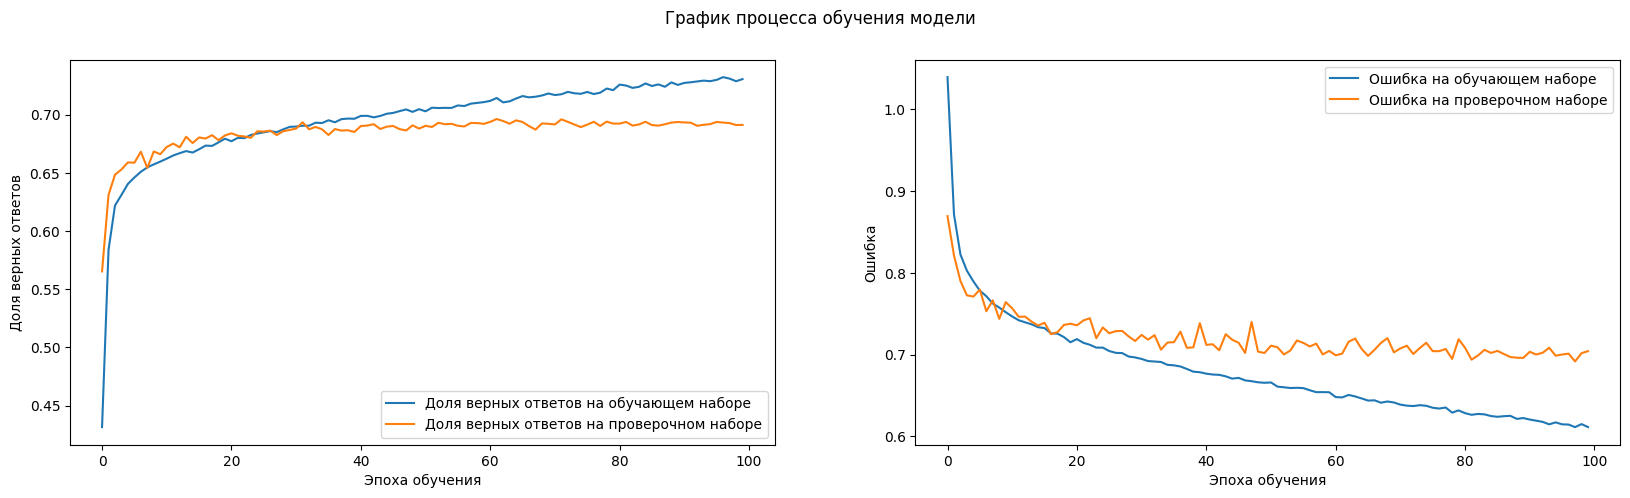

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


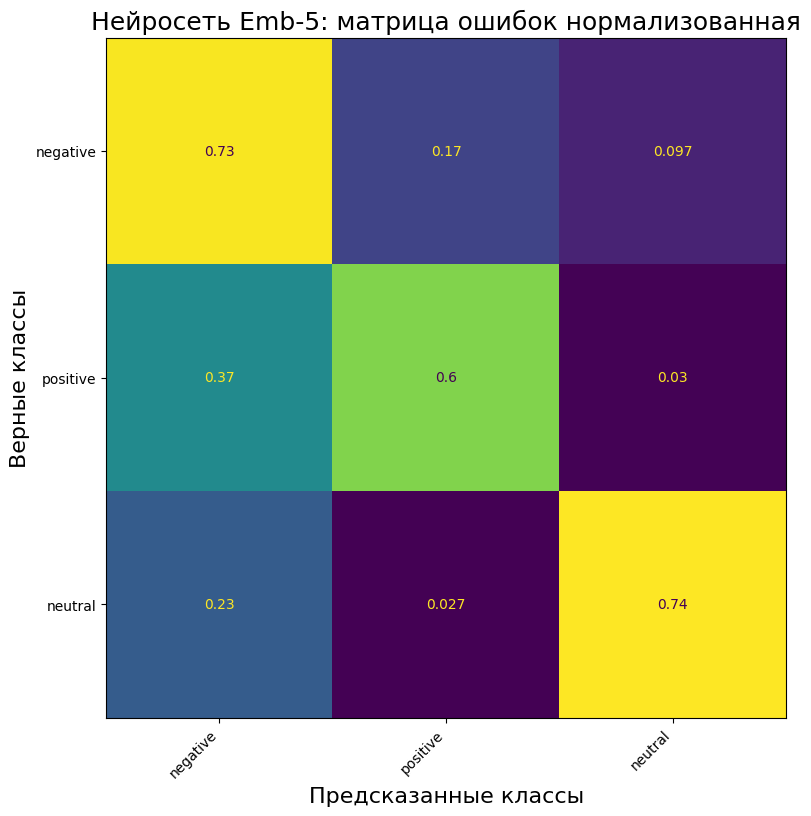

----------------------------------------------------------------------------------------------------
Нейросеть: Emb-5
Класс: negative              73% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              60% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               74% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  69%


In [8]:
class_labels = ['negative', 'positive', 'neutral']

# Создание модели
model_5 = Sequential()

model_5.add(Dense(512, input_dim=768, activation="relu"))
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation="relu"))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation="relu"))
model_5.add(Dropout(0.5))
model_5.add(Dense(64, activation="relu"))
model_5.add(Dropout(0.5))
model_5.add(Dense(32, activation="relu"))
model_5.add(Dropout(0.5))
model_5.add(Dense(16, activation="relu"))
model_5.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_5,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb-5',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=100,
                         batch_size=8)

### Модель №6

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,867 (2.17 MB)

 Trainable params: 568,867 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3417 - loss: 1.1142 - val_accuracy: 0.5539 - val_loss: 1.0496
Epoch 2/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4798 - loss: 1.0066 - val_accuracy: 0.6044 - val_loss: 0.8369
Epoch 3/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5914 - loss: 0.8731 - val_accuracy: 0.6399 - val_loss: 0.7938
Epoch 4/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6182 - loss: 0.8331 - val_accuracy: 0.6503 - val_loss: 0.7792
Epoch 5/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6310 - loss: 0.8096 - val_accuracy: 0.6610 - val_loss: 0.7624
Epoch 6/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6403 - loss: 0.7963 - val_accuracy: 0.6577 - val_loss: 0.7554
Epoch 7/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6437 - loss: 0.7798 - val_accuracy: 0.6659 - val_loss: 0.7496
Epoch 8/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6494 - loss: 0

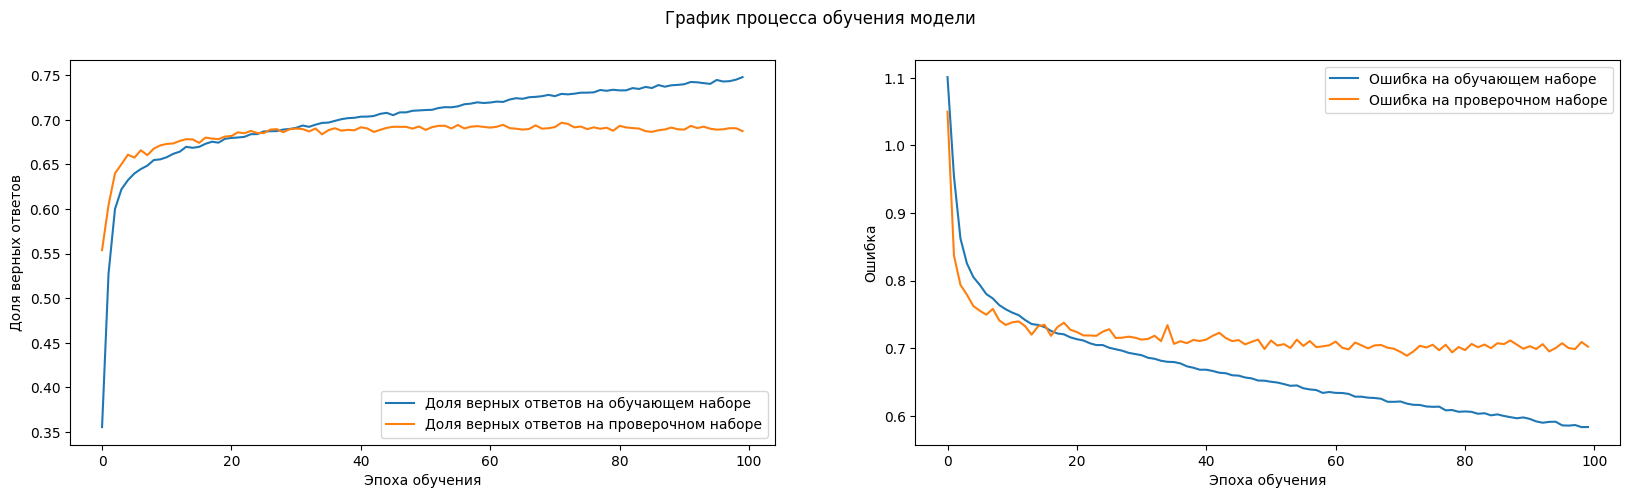

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


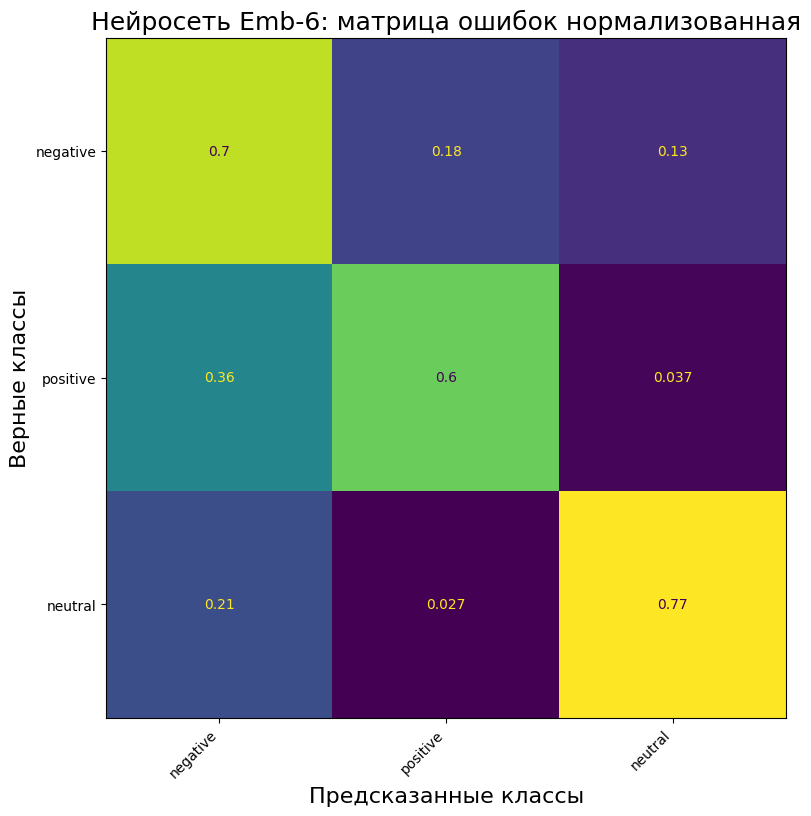

----------------------------------------------------------------------------------------------------
Нейросеть: Emb-6
Класс: negative              70% сеть отнесла к классу negative             - ВЕРНО :-)
Класс: positive              60% сеть отнесла к классу positive             - ВЕРНО :-)
Класс: neutral               77% сеть отнесла к классу neutral              - ВЕРНО :-)

Средняя точность распознавания:  69%


In [10]:
class_labels = ['negative', 'positive', 'neutral']

# Создание модели
model_6 = Sequential()

model_6.add(Dense(512, input_dim=768, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(256, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(128, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(64, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(32, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(16, activation="relu"))
model_6.add(Dense(3, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_6,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=class_labels,
                         title='Emb-6',
                         optimizer=Adam(learning_rate=0.0001),
                         epochs=100,
                         batch_size=32)

### **Результат**

Можно подвести итог ввиде таблицы:

|Params|Model_1|Model_2|Model_3|Model_4|Model_5|Model_6|
|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
|Total|4,476,875 (17.08 MB)|4,476,619 (17.08 MB)|720,587 (2.75 MB)|1,706,603 (6.51 MB)|1,706,603 (6.51 MB)|1,706,603 (6.51 MB)|
|Trainable|1,490,947 (5.69 MB)|1,490,883 (5.69 MB)|240,195 (938.26 KB)|568,867 (2.17 MB)|568,867 (2.17 MB)|568,867 (2.17 MB)|
|Non-trainable|4,032 (15.75 KB)|3,968 (15.50 KB)|0 (0.00 B)|0 (0.00 B)|0 (0.00 B)|0 (0.00 B)|
|Optimizer|2,981,896 (11.38 MB)|2,981,768 (11.37 MB)|480,392 (1.83 MB)|1,137,736 (4.34 MB)|1,137,736 (4.34 MB)|1,137,736 (4.34 MB)|
|Common accuracy|67%|64%|66%|69%|69%|69%|
|Classes accuracy|59/61/80|56/64/73|59/60/79|67/66/75|73/60/74|70/60/77|

Более лучший результат показала последняя модель, но все они меньше всего распознают позитивный класс. За основу финальной версии взята модель Model_6.